# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an Dataframe into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
# Import some libs

import pandas
import numpy as np
from sklearn.model_selection import train_test_split

## Load and process review dataset
For this assignment, we will use the same subset of the Amazon product review dataset that we used in assignment 2. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to assignment 2 for more details.

In [2]:
# Import amazon_baby.csv data to pandas dataframe
products_df = pandas.read_csv('datasets/amazon_baby_subset.csv')

import json

with open('datasets/important_words.json', 'r') as f:
    important_words = json.loads(f.read())
    
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation)

products_df = products_df.fillna({'review':''})  # fill in N/A's in the review column
products_df['review_clean'] = products_df['review'].apply(remove_punctuation)

for word in important_words:
    products_df[word] = products_df['review_clean'].apply(lambda s : s.split().count(word))

In [3]:
products_df

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried non-stop when I trie...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago. ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"One of baby's first and favorite books, and it...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book! My son loves this ...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1,"Beautiful book, I love it to record cherished ...",0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,Hunnt&reg; Falling Flowers and Birds Kids Nurs...,"Try this out for a spring project !Easy ,fun a...",5,1,"Try this out for a spring project !Easy ,fun a...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Blessed By Pope Benedict XVI Divine Mercy Full...,very nice Divine Mercy Pendant of Jesus now on...,5,1,very nice Divine Mercy Pendant of Jesus now on...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Cloth Diaper Pins Stainless Steel Traditional ...,We bought the pins as my 6 year old Autistic s...,4,1,We bought the pins as my 6 year old Autistic s...,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,Cloth Diaper Pins Stainless Steel Traditional ...,It has been many years since we needed diaper ...,5,1,It has been many years since we needed diaper ...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [4]:
np.random.seed(2)

train_data, validation_data = train_test_split(products_df, test_size=0.2)

print (train_data.shape)
print (validation_data.shape)

(42457, 198)
(10615, 198)


## Convert DataFrame to NumPy array
Just like in the second assignment of the previous module, we provide you with a function that extracts columns from an DataFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [5]:
def get_numpy_data(dataframe, features, label):
    dataframe.loc[:, 'intercept'] = 1
    features = ['intercept'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return (feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

In [6]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/usr/local/anaconda3/envs/mlp-303x/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda3/envs/mlp-303x/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Building on logistic regression with no L2 penalty assignment

Let us now build on second assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [7]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    scores = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-scores))
    # YOUR CODE HERE
    
    # return predictions
    return scores, predictions

# Adding  L2 penalty
Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [74]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE

    # add L2 penalty term for any feature that isn't the intercept.
    if feature_is_constant == True: 
        ## YOUR CODE HERE
        derivative = np.dot(errors,feature)
    else:
        derivative = np.dot(errors,feature) - 2*l2_penalty*coefficient
        
    return derivative

**Quiz Question:** In the code above, was the intercept term regularized?
<br>
**Your answer:**

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).
$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [9]:
def compute_log_likelihood_with_L2(indicator, scores, feature_matrix, sentiment, coefficients, l2_penalty):
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

**Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?
<br>
**Your answer:**

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [75]:
from math import sqrt
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        # YOUR CODE HERE
        scores, predictions = predict_probability(feature_matrix,coefficients)
        # YOUR CODE HERE

        # Compute indicator value for (y_i = +1)
        indicator = sentiment==+1

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in range(coefficients.shape[0]): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            if j == 0:
                derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,True)
            
            # YOUR CODE HERE
            else:
                derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,False)
                
            # add the step size times the derivative to the current coefficient
            # YOUR CODE HERE
            coefficients[j] += step_size*derivative
            # YOUR CODE HERE
        
        if itr % 100 == 0:
            lp = compute_log_likelihood_with_L2(indicator, scores, feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration: {}, log likelihood: {}'.format(itr, lp))

    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [76]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration: 0, log likelihood: -29428.9498450336
iteration: 100, log likelihood: -23842.350487884218
iteration: 200, log likelihood: -22394.203348885017
iteration: 300, log likelihood: -21691.39735288972
iteration: 400, log likelihood: -21268.55555312461
iteration: 500, log likelihood: -20984.535299586558


In [77]:
coefficients_0_penalty[:3]

array([-0.08526558,  0.09619947,  0.01909563])

In [78]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=4, max_iter=501)

iteration: 0, log likelihood: -29428.9527224835
iteration: 100, log likelihood: -23858.64491290947
iteration: 200, log likelihood: -22428.567727629048
iteration: 300, log likelihood: -21741.295859738377
iteration: 400, log likelihood: -21331.886549034363
iteration: 500, log likelihood: -21059.637108449257


In [79]:
coefficients_4_penalty[:3]

array([-0.08455545,  0.09592246,  0.01885984])

In [80]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=10, max_iter=501)

iteration: 0, log likelihood: -29428.95703865835
iteration: 100, log likelihood: -23882.939250684034
iteration: 200, log likelihood: -22479.517415462436
iteration: 300, log likelihood: -21814.880968100446
iteration: 400, log likelihood: -21424.79956243484
iteration: 500, log likelihood: -21169.271740978358


In [81]:
coefficients_10_penalty[:3]

array([-0.08350279,  0.09551408,  0.01851245])

In [82]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration: 0, log likelihood: -29429.0217812811
iteration: 100, log likelihood: -24227.156041121154
iteration: 200, log likelihood: -23165.837870254938
iteration: 300, log likelihood: -22761.522326559574
iteration: 400, log likelihood: -22570.902513329547
iteration: 500, log likelihood: -22470.6672543404


In [83]:
coefficients_1e2_penalty[:3]

array([-0.06938036,  0.09023208,  0.01408321])

In [84]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration: 0, log likelihood: -29429.6692075086
iteration: 100, log likelihood: -26308.983431331602
iteration: 200, log likelihood: -26223.375040933905
iteration: 300, log likelihood: -26218.094222973585
iteration: 400, log likelihood: -26217.549426847305
iteration: 500, log likelihood: -26217.463456763635


In [85]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros((194,)),
                                                     step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration: 0, log likelihood: -29500.8860925336
iteration: 100, log likelihood: -29358.071608457118
iteration: 200, log likelihood: -29358.071513157425
iteration: 300, log likelihood: -29358.07151262006
iteration: 400, log likelihood: -29358.071512616694
iteration: 500, log likelihood: -29358.07151261667


## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [86]:
table = pandas.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [87]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.085266,-0.084555,-0.083503,-0.069380,-0.009330,0.006916
1,baby,0.096199,0.095922,0.095514,0.090232,0.063927,0.001521
2,one,0.019096,0.018860,0.018512,0.014083,-0.000842,-0.001192
3,great,0.755956,0.751114,0.743982,0.653092,0.324940,0.006818
4,love,1.078871,1.071181,1.059860,0.916573,0.428104,0.008892
5,use,0.065198,0.065037,0.064799,0.061678,0.043609,0.000799
6,would,-0.297427,-0.296390,-0.294864,-0.275443,-0.193688,-0.007971
7,like,-0.015173,-0.015130,-0.015069,-0.014351,-0.010965,-0.000871
8,easy,1.019662,1.012555,1.002093,0.869633,0.413601,0.008567
9,little,0.539550,0.536478,0.531952,0.474282,0.257785,0.005859


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

In [90]:
# YOUR CODE HERE
coefficients = coefficients_0_penalty[1:] # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)

#positive_words = ...
#negative_words = list(reversed([w for w, c in word_coefficient_tuples[-10:]]))
# YOUR CODE HERE

In [111]:
positive_words = list([w for w, c in word_coefficient_tuples[:5]])

In [112]:
negative_words =list(reversed([w for w, c in word_coefficient_tuples[-5:]]))

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.loc[table['word'].isin(positive_words)]
    table_negative_words = table.loc[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

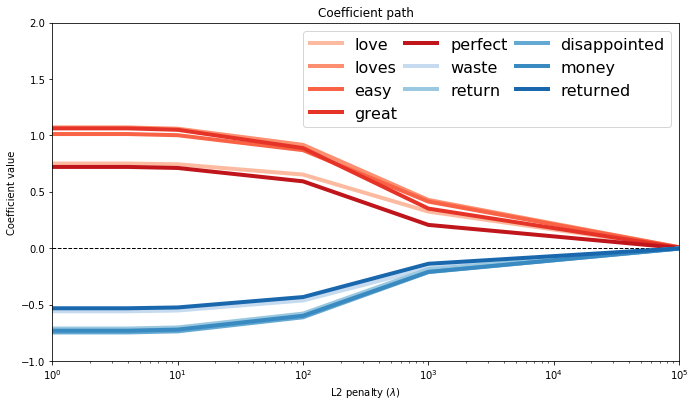

In [113]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.
<br>
**Your answer**:
<br>
**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)
<br>
**Your answer**:

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in second assignment.

In [116]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [117]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [118]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key)
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print ("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7685658430883011, validation_accuracy = 0.7689119170984456
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7684009703935747, validation_accuracy = 0.7691003297220914
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7681654379725369, validation_accuracy = 0.7691003297220914
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7667757966884141, validation_accuracy = 0.7693829486575601
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.756200390983819, validation_accuracy = 0.7566650965614696
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6887910120828132, validation_accuracy = 0.6879886952425812
---------------------------

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

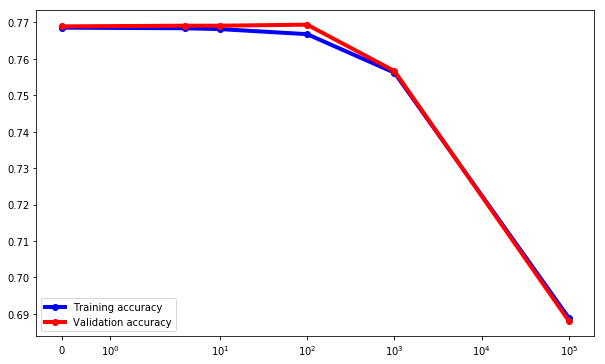

In [119]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
<br>
**Your answer**:
<br>
**Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
<br>
**Your answer**:
<br>
**Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?
<br>
**Your answer**: